This notebook explores federated learning techniques, with a particular focus on the challenges posed by data heterogeneity. Specifically, I will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

Note: In this notebook, I concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this notebook.

In [ ]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Centralized Vs Federated Scenario

I will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. 

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, we will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, we may observe discrepancies.

In [ ]:
num_clients = 5
dirichlet_alpha = 0.8  # Increase alpha for more uniform distribution
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)


In [ ]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = sum(client_data_counts)

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append((client_update_device, client_data_counts[client_id]))

            client_update_sum = sum(update.abs().sum().item() for update in client_update_device.values())
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        # Compute weighted average of client updates
        avg_update = {}
        for name in global_model.state_dict():
            weighted_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_update_device, client_data_count in client_updates:
                weighted_sum += client_update_device[name] * (client_data_count / total_data_count)
            avg_update[name] = weighted_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = sum(update.abs().sum().item() for update in avg_update.values())
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates




def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="mean")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    optimizer.zero_grad()
    x_train_list = []
    y_train_list = []

    # Load all data at once
    for x_train, y_train in train_loader:
        x_train_list.append(x_train)
        y_train_list.append(y_train)

    x_train = torch.cat(x_train_list).to(device)
    y_train = torch.cat(y_train_list).to(device)

    outputs = local_model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update



In [ ]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="mean")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}

        optimizer.zero_grad()
        x_train_list = []
        y_train_list = []

        for x_train, y_train in train_loader:
            x_train_list.append(x_train)
            y_train_list.append(y_train)

        x_train = torch.cat(x_train_list).to(device)
        y_train = torch.cat(y_train_list).to(device)

        outputs = centralized_model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name] for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = sum(update.abs().sum().item() for update in epoch_update.values())
        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [ ]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [ ]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

Using device: cuda
Epoch 1/4
Epoch 1 Update Sum: 0.007811258536094101
Epoch 2/4
Epoch 2 Update Sum: 0.00781123734486755
Epoch 3/4
Epoch 3 Update Sum: 0.007810968403646257
Epoch 4/4
Epoch 4 Update Sum: 0.007811057434082613


In [ ]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

Using device: cuda
Round 1/4
Client 1 Update Sum at Round 1: 0.028480232880610856
Client 2 Update Sum at Round 1: 0.031901279849989805
Client 3 Update Sum at Round 1: 0.02484075456413848
Client 4 Update Sum at Round 1: 0.03475176506071875
Client 5 Update Sum at Round 1: 0.024114431067573605
Averaged Update Sum at Round 1: 0.007820287885010657
Round 2/4
Client 1 Update Sum at Round 2: 0.028480321900133276
Client 2 Update Sum at Round 2: 0.0319013697153423
Client 3 Update Sum at Round 2: 0.024840408717864193
Client 4 Update Sum at Round 2: 0.034750889251881745
Client 5 Update Sum at Round 2: 0.02411459722497966
Averaged Update Sum at Round 2: 0.007820214803814451
Round 3/4
Client 1 Update Sum at Round 3: 0.02848012003596523
Client 2 Update Sum at Round 3: 0.03190113411983475
Client 3 Update Sum at Round 3: 0.024840005611622473
Client 4 Update Sum at Round 3: 0.03474987964546017
Client 5 Update Sum at Round 3: 0.02411451958687394
Averaged Update Sum at Round 3: 0.007819970267519238
Round 

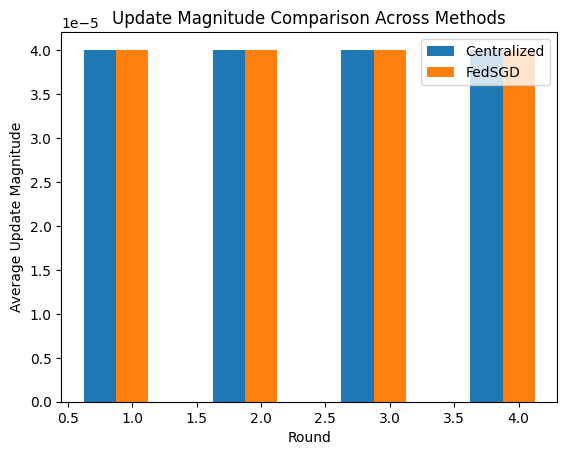

Success! The gradients are approximately the same.


In [ ]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

# FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [ ]:
import copy


def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [ ]:
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    for r in range(rounds):
        print(f"Round {r + 1}/{rounds}")

        client_updates = []
        for client_id in range(num_clients):
            print(f"Training Client {client_id}")

            local_model = copy.deepcopy(global_model)
            local_model.to(device)

            client_update = local_train(local_model, train_loaders[client_id], epochs, lr)
            client_updates.append(client_update)

        avg_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for update in client_updates:
            for name in avg_update:
                avg_update[name] += update[name] / num_clients

        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += avg_update[name]
        global_model.load_state_dict(global_model_state)

        round_avg_updates.append(avg_update)

        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

    return round_avg_updates, round_accuracies


def local_train(model, train_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    initial_state = {name: param.clone() for name, param in model.state_dict().items()}

    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    final_state = model.state_dict()
    overall_update = {name: final_state[name] - initial_state[name] for name in initial_state}

    return overall_update


In the following code you may change the learning rate or the batch size

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 5
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 1.5, 1, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)


Round 1/5
Training Client 0
Training Client 1
Training Client 2
Training Client 3
Training Client 4

Evaluating Client 0
Client 0 Accuracy: 29.30%

Evaluating Client 1
Client 1 Accuracy: 31.22%

Evaluating Client 2
Client 2 Accuracy: 31.07%

Evaluating Client 3
Client 3 Accuracy: 19.70%

Evaluating Client 4
Client 4 Accuracy: 19.14%
Total Accuracy: 25.63%
Round 2/5
Training Client 0
Training Client 1
Training Client 2
Training Client 3
Training Client 4

Evaluating Client 0
Client 0 Accuracy: 57.59%

Evaluating Client 1
Client 1 Accuracy: 57.02%

Evaluating Client 2
Client 2 Accuracy: 58.48%

Evaluating Client 3
Client 3 Accuracy: 59.50%

Evaluating Client 4
Client 4 Accuracy: 47.53%
Total Accuracy: 55.97%
Round 3/5
Training Client 0
Training Client 1
Training Client 2
Training Client 3
Training Client 4

Evaluating Client 0
Client 0 Accuracy: 65.94%

Evaluating Client 1
Client 1 Accuracy: 67.02%

Evaluating Client 2
Client 2 Accuracy: 70.20%

Evaluating Client 3
Client 3 Accuracy: 72.

In [ ]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

# SCAFFOLD

In this task, we will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [ ]:
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr):
    """
    Performs local training using SCAFFOLD algorithm with momentum
    """
    print(f"\nStarting local training with learning rate: {lr}")

    initial_params = {name: param.clone() for name, param in model.named_parameters()}

    momentum_buffer = {name: torch.zeros_like(param) for name, param in model.named_parameters()}

    overall_update = {name: torch.zeros_like(param) for name, param in model.named_parameters()}

    model.train()
    total_batches = len(train_loader)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
            outputs = model(batch_data)
            loss = F.cross_entropy(outputs, batch_labels)
            epoch_loss += loss.item()

            loss.backward()

            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is None:
                        continue

                    corrected_grad = param.grad + c_global[name] - c_local[name]

                    momentum_buffer[name].mul_(mu).add_(corrected_grad)

                    param.data.add_(momentum_buffer[name], alpha=-lr)

                    param.grad = None

            # if (batch_idx + 1) % 10 == 0:
                # print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{total_batches}] Loss: {loss.item():.4f}")

        avg_epoch_loss = epoch_loss / total_batches
        print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_epoch_loss:.4f}")

    with torch.no_grad():
        for name, param in model.named_parameters():
            overall_update[name] = initial_params[name] - param

    new_c_local = {}
    for name in overall_update:
        new_c_local[name] = (
            c_local[name] -
            c_global[name] +
            overall_update[name] / (epochs * len(train_loader) * lr)
        )

    print("Local training completed")
    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    """
    Implements the SCAFFOLD federated learning algorithm
    """
    print(f"\nStarting SCAFFOLD training with {num_clients} clients")
    print(f"Training for {rounds} rounds with {epochs} local epochs each")
    print(f"Local learning rate: {local_lr}")

    round_accuracies = []

    c_global = {name: torch.zeros_like(param) for name, param in global_model.named_parameters()}

    c_locals = [{name: torch.zeros_like(param) for name, param in global_model.named_parameters()}
                for _ in range(num_clients)]

    global_lr = 1.0

    for round_num in range(rounds):
        print(f"\n=== Starting Round {round_num + 1}/{rounds} ===")

        selected_clients = range(num_clients)
        client_updates = []
        new_c_locals = []

        for client_idx in selected_clients:
            print(f"\nTraining Client {client_idx + 1}/{num_clients}")

            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            update, new_c_local = local_train_scaffold(
                local_model,
                train_loaders[client_idx],
                c_global,
                c_locals[client_idx],
                epochs,
                local_lr
            )

            client_updates.append(update)
            new_c_locals.append(new_c_local)

        print("\nUpdating global model with client updates")
        with torch.no_grad():
            for name, param in global_model.named_parameters():
                update_avg = torch.stack([updates[name] for updates in client_updates]).mean(0)
                param.sub_(update_avg, alpha=global_lr)

        for name in c_global:
            c_update = torch.stack([c[name] - c_locals[i][name]
                                  for i, c in enumerate(new_c_locals)]).mean(0)
            c_global[name].add_(c_update)

        c_locals = new_c_locals

        print("\nEvaluating global model")
        total_correct = 0
        total_samples = 0
        global_model.eval()

        with torch.no_grad():
            for client_idx, test_loader in enumerate(test_loaders):
                client_correct = 0
                client_total = 0
                for data, target in test_loader:
                    output = global_model(data)
                    pred = output.argmax(dim=1)
                    client_correct += pred.eq(target).sum().item()
                    client_total += len(target)

                print(f"Client {client_idx + 1} Test Accuracy: {100.0 * client_correct / client_total:.2f}%")
                total_correct += client_correct
                total_samples += client_total

        accuracy = 100.0 * total_correct / total_samples
        round_accuracies.append(accuracy)
        print(f"\nRound {round_num + 1} Overall Accuracy: {accuracy:.2f}%")

    return round_accuracies

In [ ]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01  # local learning rate
mu = 0.001  # momentum parameter
batch_size = 32

def run_scaffold():
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels,
                                                    test_images / 255, test_labels,
                                                    num_clients, 0.1, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders,
                                        test_loaders, num_clients, rounds,
                                        epochs, local_lr=lr)
    return round_accuracies

scaffold_accuracies = run_scaffold()


Starting SCAFFOLD training with 5 clients
Training for 3 rounds with 20 local epochs each
Local learning rate: 0.01

=== Starting Round 1/3 ===

Training Client 1/5

Starting local training with learning rate: 0.01
Epoch [1/20] Average Loss: 0.4250
Epoch [2/20] Average Loss: 0.2494
Epoch [3/20] Average Loss: 0.2275
Epoch [4/20] Average Loss: 0.2153
Epoch [5/20] Average Loss: 0.2017
Epoch [6/20] Average Loss: 0.1852
Epoch [7/20] Average Loss: 0.1660
Epoch [8/20] Average Loss: 0.1456
Epoch [9/20] Average Loss: 0.1261
Epoch [10/20] Average Loss: 0.1098
Epoch [11/20] Average Loss: 0.0971
Epoch [12/20] Average Loss: 0.0873
Epoch [13/20] Average Loss: 0.0798
Epoch [14/20] Average Loss: 0.0739
Epoch [15/20] Average Loss: 0.0689
Epoch [16/20] Average Loss: 0.0649
Epoch [17/20] Average Loss: 0.0615
Epoch [18/20] Average Loss: 0.0585
Epoch [19/20] Average Loss: 0.0561
Epoch [20/20] Average Loss: 0.0540
Local training completed

Training Client 2/5

Starting local training with learning rate: 0.

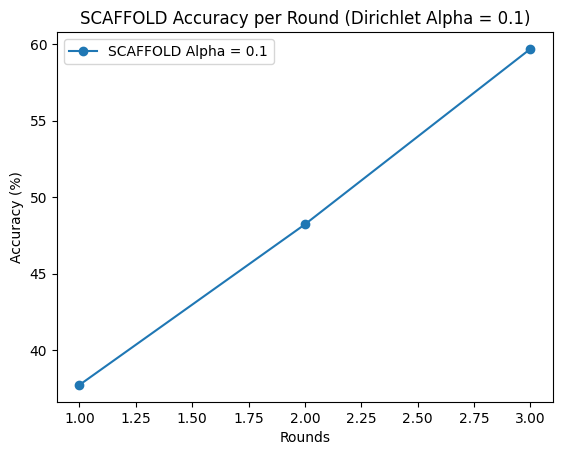

In [ ]:
plt.figure()
plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()

In [ ]:
print(scaffold_accuracies)

[37.725, 48.21666666666667, 59.68333333333333]


# FedSAM

In this task, we will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, we evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [ ]:
def apply_sam_perturbation(model, batch_data, batch_labels, rho):
    original_params = {name: param.clone()
                      for name, param in model.named_parameters()}

    outputs = model(batch_data)
    loss = F.cross_entropy(outputs, batch_labels)

    loss.backward()

    with torch.no_grad():
        grad_norm = torch.norm(
            torch.stack([
                torch.norm(param.grad.detach())
                for param in model.parameters()
            ]))

        for name, param in model.named_parameters():
            if param.grad is None:
                continue

            e_w = param.grad * rho / (grad_norm + 1e-12)

            param.add_(e_w)

    model.zero_grad()

    return original_params

def local_train_sam(model, train_loader, epochs, lr, rho=0.1):
    initial_params = {name: param.clone()
                     for name, param in model.named_parameters()}

    overall_update = {name: torch.zeros_like(param)
                     for name, param in model.named_parameters()}

    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch_data, batch_labels in train_loader:
            outputs = model(batch_data)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            grad_norm = torch.norm(
                torch.stack([
                    torch.norm(p.grad.detach())
                    for p in model.parameters()
                    if p.grad is not None
                ])
            )

            perturbations = {}

            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        e_w = param.grad * rho / (grad_norm + 1e-12)
                        perturbations[name] = e_w.clone()
                        param.add_(e_w)

            outputs = model(batch_data)
            loss = F.cross_entropy(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()

            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        param.sub_(perturbations[name])

            optimizer.step()

    with torch.no_grad():
        for name, param in model.named_parameters():
            overall_update[name] = initial_params[name] - param

    return overall_update

def federated_training_sam(global_model, train_loaders, test_loaders,
                         num_clients, rounds, epochs, local_lr):


    print(f"\nStarting FedSAM training with {num_clients} clients")
    print(f"Training for {rounds} rounds with {epochs} local epochs each")
    print(f"Local learning rate: {local_lr}")

    round_accuracies = []
    global_lr = 1.0

    for round_num in range(rounds):
        print(f"\n=== Starting Round {round_num + 1}/{rounds} ===")

        selected_clients = range(num_clients)
        print(f"Selected {len(selected_clients)} clients for this round")

        client_updates = []

        for client_idx in selected_clients:
            print(f"\nTraining Client {client_idx + 1}/{num_clients}")

            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            num_samples = sum(len(batch[0]) for batch in train_loaders[client_idx])
            print(f"Client {client_idx + 1} has {num_samples} training samples")

            update = local_train_sam(
                local_model,
                train_loaders[client_idx],
                epochs,
                local_lr
            )

            client_updates.append(update)
            print(f"Client {client_idx + 1} training completed")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                update_avg = torch.stack([updates[name]
                                        for updates in client_updates]).mean(0)
                param.sub_(global_lr * update_avg)

        print("\nEvaluating global model")
        total_correct = 0
        total_samples = 0
        global_model.eval()

        with torch.no_grad():
            for client_idx, test_loader in enumerate(test_loaders):
                client_correct = 0
                client_total = 0
                for data, target in test_loader:
                    output = global_model(data)
                    pred = output.argmax(dim=1)
                    client_correct += pred.eq(target).sum().item()
                    client_total += len(target)

                print(f"Client {client_idx + 1} Test Accuracy: "
                      f"{100.0 * client_correct / client_total:.2f}%")
                total_correct += client_correct
                total_samples += client_total

        accuracy = 100.0 * total_correct / total_samples
        round_accuracies.append(accuracy)
        print(f"\nRound {round_num + 1} Overall Accuracy: {accuracy:.2f}%")

    print("\nFedSAM training completed!")
    return round_accuracies

In [ ]:
num_clients = 5
rounds = 3
epochs = 20
local_lr = 0.01  # Local learning rate (η_l)
global_lr = 1.0  # Global learning rate (η_g)
rho = 0.1       # SAM's perturbation parameter
batch_size = 32 # For EMNIST

def run_fedsam():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(
        train_images / 255, train_labels,
        test_images / 255, test_labels,
        num_clients, 0.1, batch_size)

    global_model_sam = SimpleCNN()
    round_accuracies = federated_training_sam(
        global_model_sam, train_loaders, test_loaders,
        num_clients, rounds, epochs,
        local_lr=local_lr)
    return round_accuracies

sam_accuracies = run_fedsam()


Starting FedSAM training with 5 clients
Training for 3 rounds with 20 local epochs each
Local learning rate: 0.01

=== Starting Round 1/3 ===
Selected 5 clients for this round

Training Client 1/5
Client 1 has 6815 training samples
Client 1 training completed

Training Client 2/5
Client 2 has 12849 training samples
Client 2 training completed

Training Client 3/5
Client 3 has 11838 training samples
Client 3 training completed

Training Client 4/5
Client 4 has 4628 training samples
Client 4 training completed

Training Client 5/5
Client 5 has 11870 training samples
Client 5 training completed

Evaluating global model
Client 1 Test Accuracy: 14.64%
Client 2 Test Accuracy: 46.71%
Client 3 Test Accuracy: 23.15%
Client 4 Test Accuracy: 19.03%
Client 5 Test Accuracy: 46.75%

Round 1 Overall Accuracy: 33.70%

=== Starting Round 2/3 ===
Selected 5 clients for this round

Training Client 1/5
Client 1 has 6815 training samples
Client 1 training completed

Training Client 2/5
Client 2 has 12849 

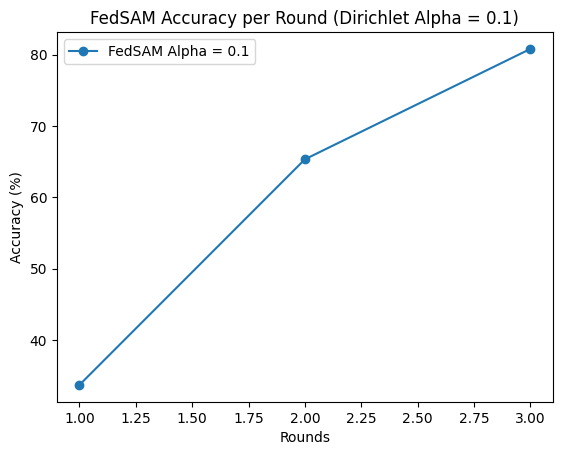

In [ ]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1
plt.figure()
plt.plot(range(1, rounds + 1), sam_accuracies, marker='o', label='FedSAM Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedSAM Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()